# DKL with Mixed models

Inputs -  ICCD images and depositioin params(F1, F2, P, T);
Outputs - score (Raman peak prominence)


Ganesh Narasimha

# Imports

In [1]:
import matplotlib.pylab as plt
import numpy as np

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset



In [2]:
# Import GP and BoTorch functions
import gpytorch as gpt
import pandas as pd
from botorch.models import SingleTaskGP, ModelListGP

#from botorch.models import gpytorch
# from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm


In [3]:

from GP_functions import *
from custom_models import *
from ICCD_Dataset import *
from Plot_DKL_predictions import *


# Functions

In [4]:

def norm_0to1_tensor(X):

    norm_tensor = torch.empty_like(X)

    for i in range(X.shape[-1]):
        torch_i = X[:, i]
        norm_i = (torch_i - torch.min(torch_i))/(torch.max(torch_i) - torch.min(torch_i))
        norm_tensor[:, i] = norm_i
           
    return norm_tensor

def extract_data(dataloader, norm = True):
    images = []
    params =[]
    scores = []
    indices = []

    for i, (images_i, params_i, score_i) in enumerate(dataloader):

        images.append(images_i)
        params.append(params_i)
        scores.append(score_i)

        indices.append(i)

    

    images = torch.cat(images, axis=0)
    params = torch.cat(params, axis=0)
    scores = torch.cat(scores, axis=0)
    indices = np.array(indices)
    

    if norm:
        params = norm_0to1_tensor(params)
        scores = norm_0to1_tensor(scores)

    return images, params, scores, indices


def append_to_train(X, y, params, X_train, y_train, train_params, train_indices, ind):
    X_train = torch.cat((X_train, X[ind:ind+1]), axis=0)
    y_train = torch.cat((y_train, y[ind:ind+1]), axis=0)
    train_params = torch.cat((train_params, params[ind:ind+1]), axis=0)
    train_indices = np.hstack((train_indices, ind))

    return X_train, y_train, train_params, train_indices

# Get dataset

In [39]:
datafile = 'data/PLD data.json'

# Get the raw dataset, wo transforms
dataset1 = ICCDDataset(datafile)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])


In [41]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score, _ = extract_data(dataloader, norm = False)

X, params, y, indices = extract_data(dataloader)




In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([304, 1, 50, 40, 40]) torch.Size([304, 1]) torch.Size([77, 1, 50, 40, 40]) torch.Size([77, 1])


# DKL with Custom_nn

## Single step training

In [8]:
from custom_models import DKL_Custom_nn, MLP, ICCDNet, MixedICCDNet

In [9]:
custom_nn = MixedICCDNet(output_dim = 3)

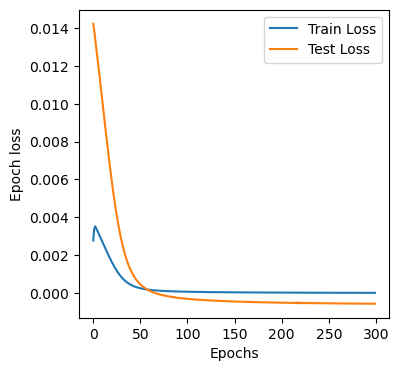

Training_loss:  -3.2232022939523162e-06


In [10]:

model, training_loss, test_loss = train_test_mixed_nn_DKL(train_dataset, test_dataset, custom_nn, num_epochs = 300, plot_loss = True, n_batches = 1)
print("Training_loss: ",training_loss[-1])

In [11]:
y_means, y_vars = DKL_posterior(model, X, params)
y_means.shape, y_vars.shape

#y_means, y_vars = model.posterior(X, params)

(torch.Size([381, 1]), torch.Size([381, 1]))

In [12]:
acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y)
ind = np.random.choice(acq_ind)

print(ind)

195


## Active learning

In [65]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.9)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
initial_train = len(train_dataset)

torch.Size([38, 1, 50, 40, 40]) torch.Size([38, 1]) torch.Size([343, 1, 50, 40, 40]) torch.Size([343, 1])


In [43]:
#Set the number of exploration steps
exploration_steps = 50
beta = 1

for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")

    custom_nn = MixedICCDNet(output_dim = 3)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    # Contruct the GP surrogate function
    model, training_loss = train_mixed_nn_DKL(train_dataset, custom_nn, num_epochs = 200, device= device)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X, params = params)

    # Calculate the acquisition function
    #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)
    
    beta = 0.9*beta
    acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices)

    # best estimates
    #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)

    ind = np.random.choice(acq_ind)
   

    #Next measurement point
    #next_X = X[ind,:]
    next_score = score[ind,:]
    
    # #Plot the results
    # plot_results(X_train, y_train, X, y_means, y_vars, Acq_vals, X_best_train, ind)

    #Print the results
    #print("Next Acquisition at: ", next_X)
    print("Next-index: ",ind)
    print("Measured score: ", next_score.item())
   

    #Update training data
    train_X, train_y, train_params, train_indices = append_to_train(X, y, params, train_X, train_y, train_params, train_indices, ind)
    


------------------Exploration Step:1 ----------------------- 


training_loss 0.007120535076786832
Next-index:  153
Measured score:  4.02393102645874

------------------Exploration Step:2 ----------------------- 


training_loss -0.021276365473161352
Next-index:  253
Measured score:  26.609310150146484

------------------Exploration Step:3 ----------------------- 


training_loss -0.013633772395300203
Next-index:  52
Measured score:  347.1290283203125

------------------Exploration Step:4 ----------------------- 


training_loss 0.0034096362510660687
Next-index:  249
Measured score:  3.0577242374420166

------------------Exploration Step:5 ----------------------- 


training_loss 0.15615240767911528
Next-index:  212
Measured score:  0.06762811541557312

------------------Exploration Step:6 ----------------------- 


training_loss 0.008234235805648903
Next-index:  68
Measured score:  169.99240112304688

------------------Exploration Step:7 ----------------------- 


training_loss 0.0026642333656816094
Next-index:  372
Measured score:  50.02471160888672

------------------Exploration Step:8 ----------------------- 


training_loss 0.01646188751194904
Next-index:  206
Measured score:  81.03068542480469

------------------Exploration Step:9 ----------------------- 


training_loss -0.01430508673400492
Next-index:  124
Measured score:  40.022579193115234

------------------Exploration Step:10 ----------------------- 


training_loss 0.013743238770308589
Next-index:  314
Measured score:  144.25552368164062

------------------Exploration Step:11 ----------------------- 


training_loss -0.017651379377316173
Next-index:  98
Measured score:  0.01925245299935341

------------------Exploration Step:12 ----------------------- 


training_loss 0.01835241135169548
Next-index:  137
Measured score:  68.01658630371094

------------------Exploration Step:13 ----------------------- 


training_loss 0.1773373599314418
Next-index:  173
Measured score:  0.5399634838104248

------------------Exploration Step:14 ----------------------- 


training_loss -0.0015279621999764424
Next-index:  332
Measured score:  1.029726266860962

------------------Exploration Step:15 ----------------------- 


training_loss 0.015075136857881775
Next-index:  15
Measured score:  0.0

------------------Exploration Step:16 ----------------------- 


training_loss 0.009130461913609894
Next-index:  348
Measured score:  0.606521487236023

------------------Exploration Step:17 ----------------------- 


training_loss -0.014460850147604468
Next-index:  75
Measured score:  0.0

------------------Exploration Step:18 ----------------------- 


training_loss -0.014138786006575792
Next-index:  105
Measured score:  1.1697279214859009

------------------Exploration Step:19 ----------------------- 


training_loss 0.003750786243239064
Next-index:  71
Measured score:  131.98898315429688

------------------Exploration Step:20 ----------------------- 


training_loss -0.010489804873617954
Next-index:  8
Measured score:  1.2174030542373657

------------------Exploration Step:21 ----------------------- 


training_loss 0.017629988643248
Next-index:  323
Measured score:  0.5432382822036743

------------------Exploration Step:22 ----------------------- 


training_loss 0.20939835815259544
Next-index:  364
Measured score:  137.01795959472656

------------------Exploration Step:23 ----------------------- 


training_loss 0.029211509113975964
Next-index:  97
Measured score:  0.4913118779659271

------------------Exploration Step:24 ----------------------- 


training_loss -0.019664403108241725
Next-index:  107
Measured score:  0.42623335123062134

------------------Exploration Step:25 ----------------------- 


training_loss 0.06720496416543799
Next-index:  185
Measured score:  0.43695908784866333

------------------Exploration Step:26 ----------------------- 


training_loss -0.014628802664294017
Next-index:  193
Measured score:  195.92523193359375

------------------Exploration Step:27 ----------------------- 


training_loss 0.0002423304569756585
Next-index:  230
Measured score:  0.0

------------------Exploration Step:28 ----------------------- 


training_loss -0.007473083549196566
Next-index:  143
Measured score:  2.042867422103882

------------------Exploration Step:29 ----------------------- 


training_loss -0.02034922235761723
Next-index:  268
Measured score:  175.1049041748047

------------------Exploration Step:30 ----------------------- 


training_loss -0.016923372520934156
Next-index:  313
Measured score:  525.7086181640625

------------------Exploration Step:31 ----------------------- 


training_loss -0.008346516776496397
Next-index:  309
Measured score:  0.3775647282600403

------------------Exploration Step:32 ----------------------- 


training_loss 0.026970674112384182
Next-index:  5
Measured score:  14.332141876220703

------------------Exploration Step:33 ----------------------- 


training_loss -0.0022522841520284916
Next-index:  293
Measured score:  0.11313939839601517

------------------Exploration Step:34 ----------------------- 


training_loss -0.010724646861615172
Next-index:  43
Measured score:  0.0

------------------Exploration Step:35 ----------------------- 


training_loss 0.016733214259226876
Next-index:  194
Measured score:  610.6161499023438

------------------Exploration Step:36 ----------------------- 


training_loss 0.007717939671435565
Next-index:  164
Measured score:  97.2035903930664

------------------Exploration Step:37 ----------------------- 


training_loss -0.0220100813992415
Next-index:  101
Measured score:  0.8046125769615173

------------------Exploration Step:38 ----------------------- 


training_loss -0.009169885294658106
Next-index:  31
Measured score:  0.5197494029998779

------------------Exploration Step:39 ----------------------- 


training_loss -0.021639805446347526
Next-index:  278
Measured score:  0.37942591309547424

------------------Exploration Step:40 ----------------------- 


training_loss 0.011390916397761833
Next-index:  267
Measured score:  0.5437436699867249

------------------Exploration Step:41 ----------------------- 


training_loss -0.005830717451627384
Next-index:  61
Measured score:  181.85836791992188

------------------Exploration Step:42 ----------------------- 


training_loss -0.015549319286560826
Next-index:  120
Measured score:  6.677504539489746

------------------Exploration Step:43 ----------------------- 


training_loss 0.017152930101570433
Next-index:  298
Measured score:  193.71707153320312

------------------Exploration Step:44 ----------------------- 


training_loss -0.0003547498793808187
Next-index:  47
Measured score:  370.1125183105469

------------------Exploration Step:45 ----------------------- 


training_loss -0.005486256705065767
Next-index:  172
Measured score:  39.98207092285156

------------------Exploration Step:46 ----------------------- 


training_loss -0.01742213727711707
Next-index:  20
Measured score:  183.39834594726562

------------------Exploration Step:47 ----------------------- 


training_loss 0.009980059900931267
Next-index:  245
Measured score:  50.02471160888672

------------------Exploration Step:48 ----------------------- 


training_loss -0.012877133462043257
Next-index:  273
Measured score:  1.6521241664886475

------------------Exploration Step:49 ----------------------- 


training_loss 0.02285429466048457
Next-index:  184
Measured score:  4.523035526275635

------------------Exploration Step:50 ----------------------- 


training_loss -0.014060926207852728
Next-index:  316
Measured score:  0.5747506618499756


## Results

In [67]:
score_np = score.detach().squeeze().numpy()
initial_train_indices = train_indices[0:initial_train]
active_learning_indices = train_indices[initial_train:]

print("Inital training score:", score_np[initial_train_indices].mean())
print("Average dataset score:", score_np.mean())
print("Average Active-learning score:", score_np[active_learning_indices].mean()) 


Inital training score: 98.10676
Average dataset score: 77.027756
Average Active-learning score: nan


/tmp/ipykernel_882988/1810076980.py:9: RuntimeWarning: Mean of empty slice.
  print("Average Active-learning score:", score_np[active_learning_indices].mean())


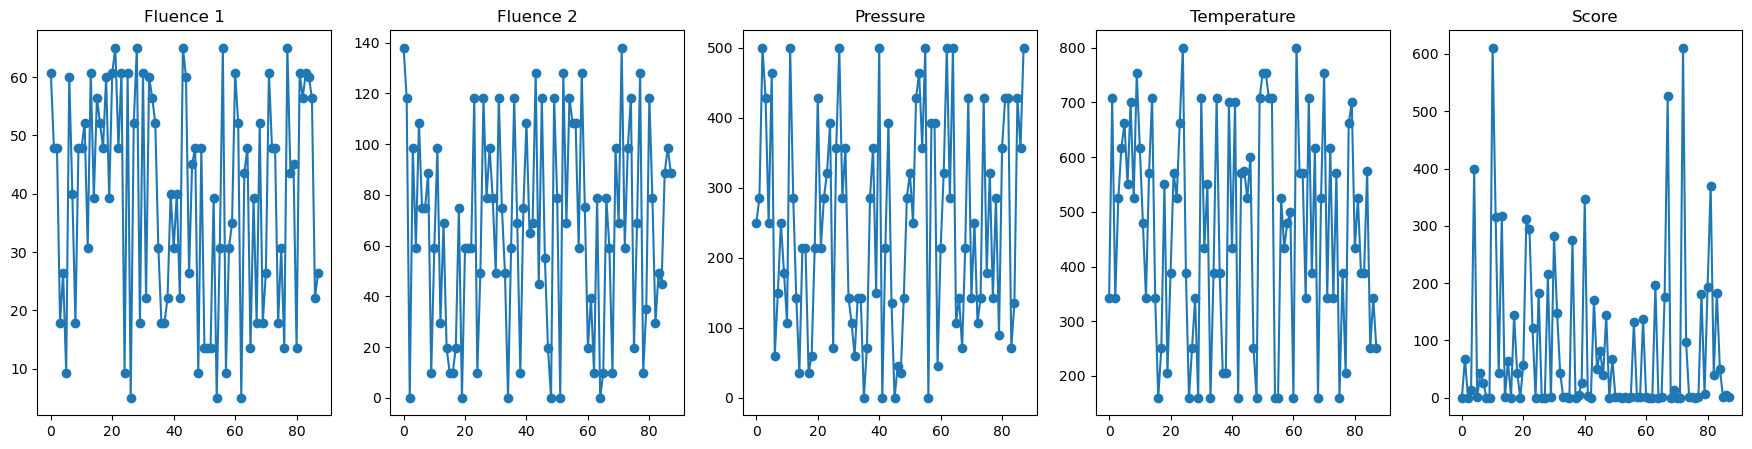

In [44]:
from Plot_DKL_predictions import plot_train_series, plot_train_hist, plot_mean_map
plot_train_series(train_indices, orig_params, score)

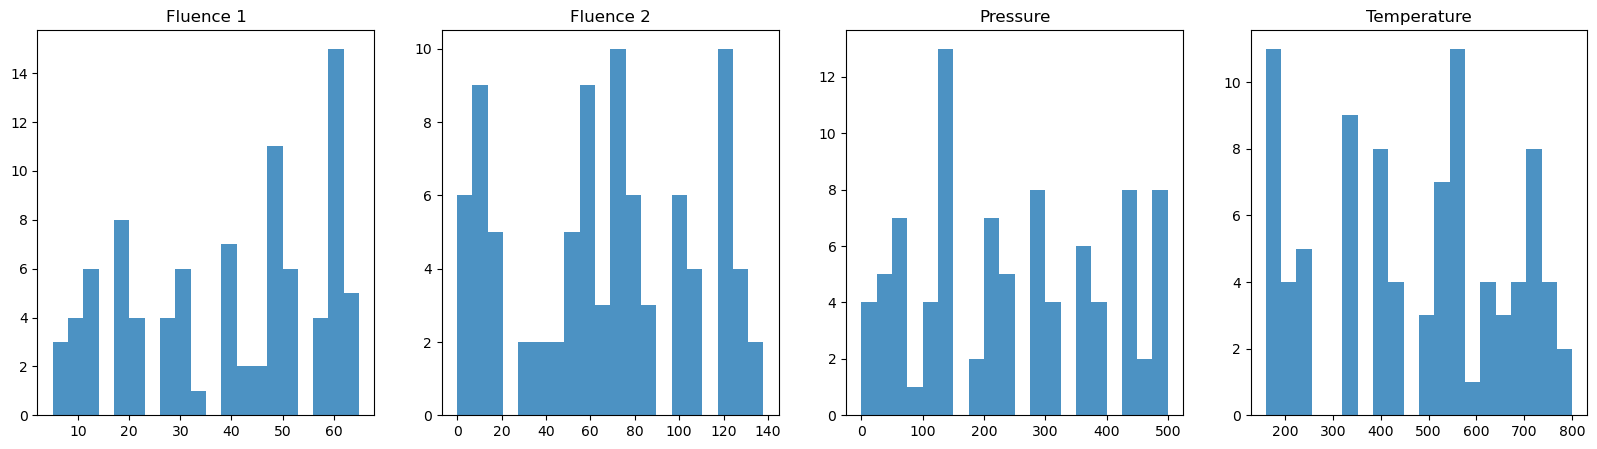

In [45]:
plot_train_hist(train_indices, orig_params)

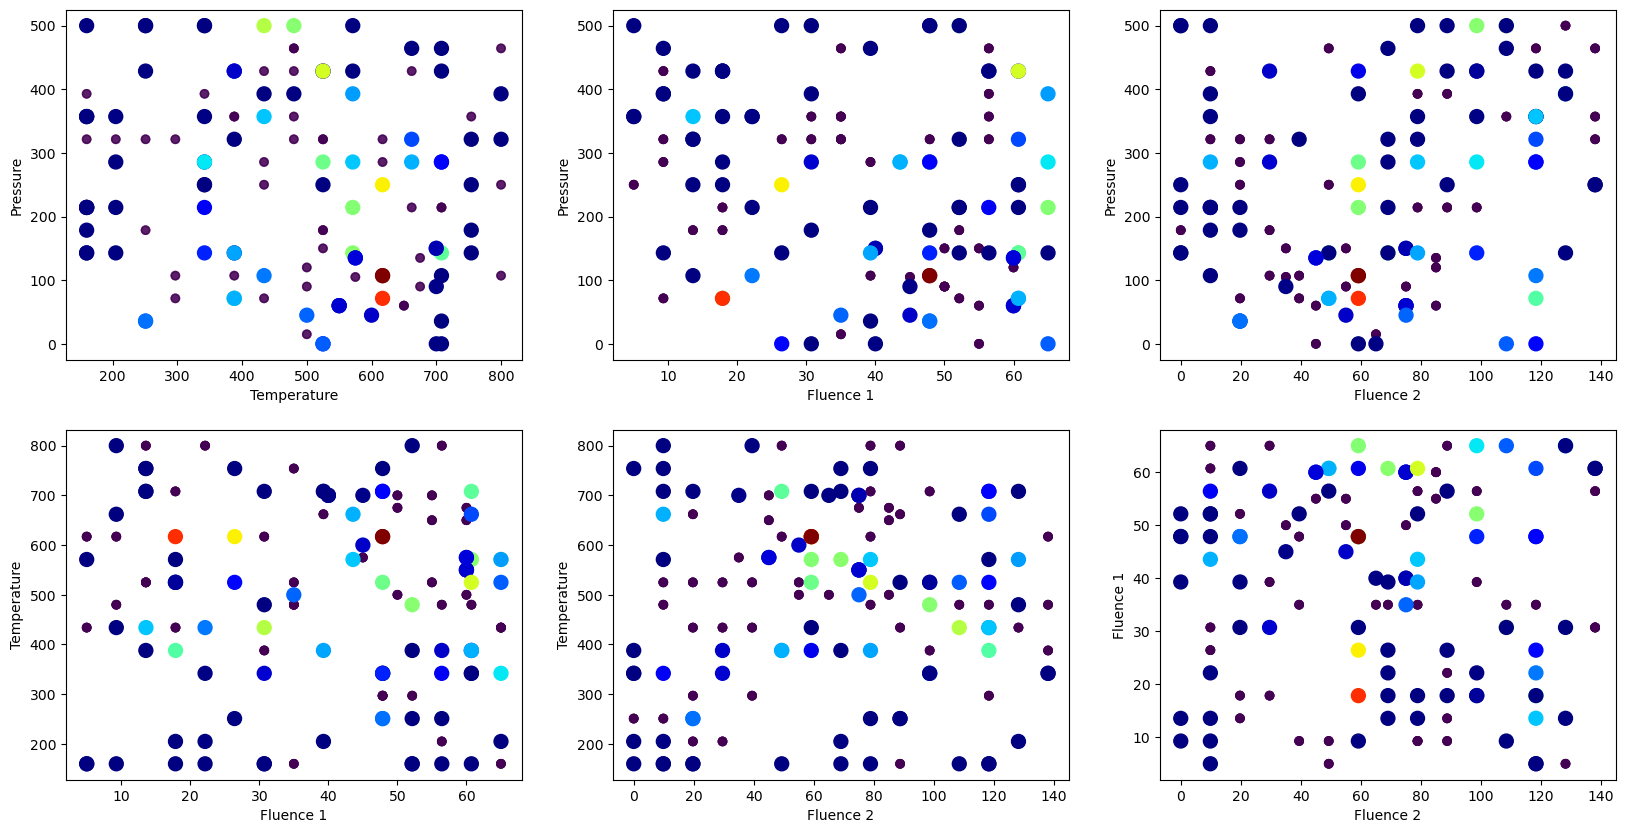

In [46]:
plot_mean_map(y_means, train_indices, orig_params, score)

training_loss 0.0011543104933066802


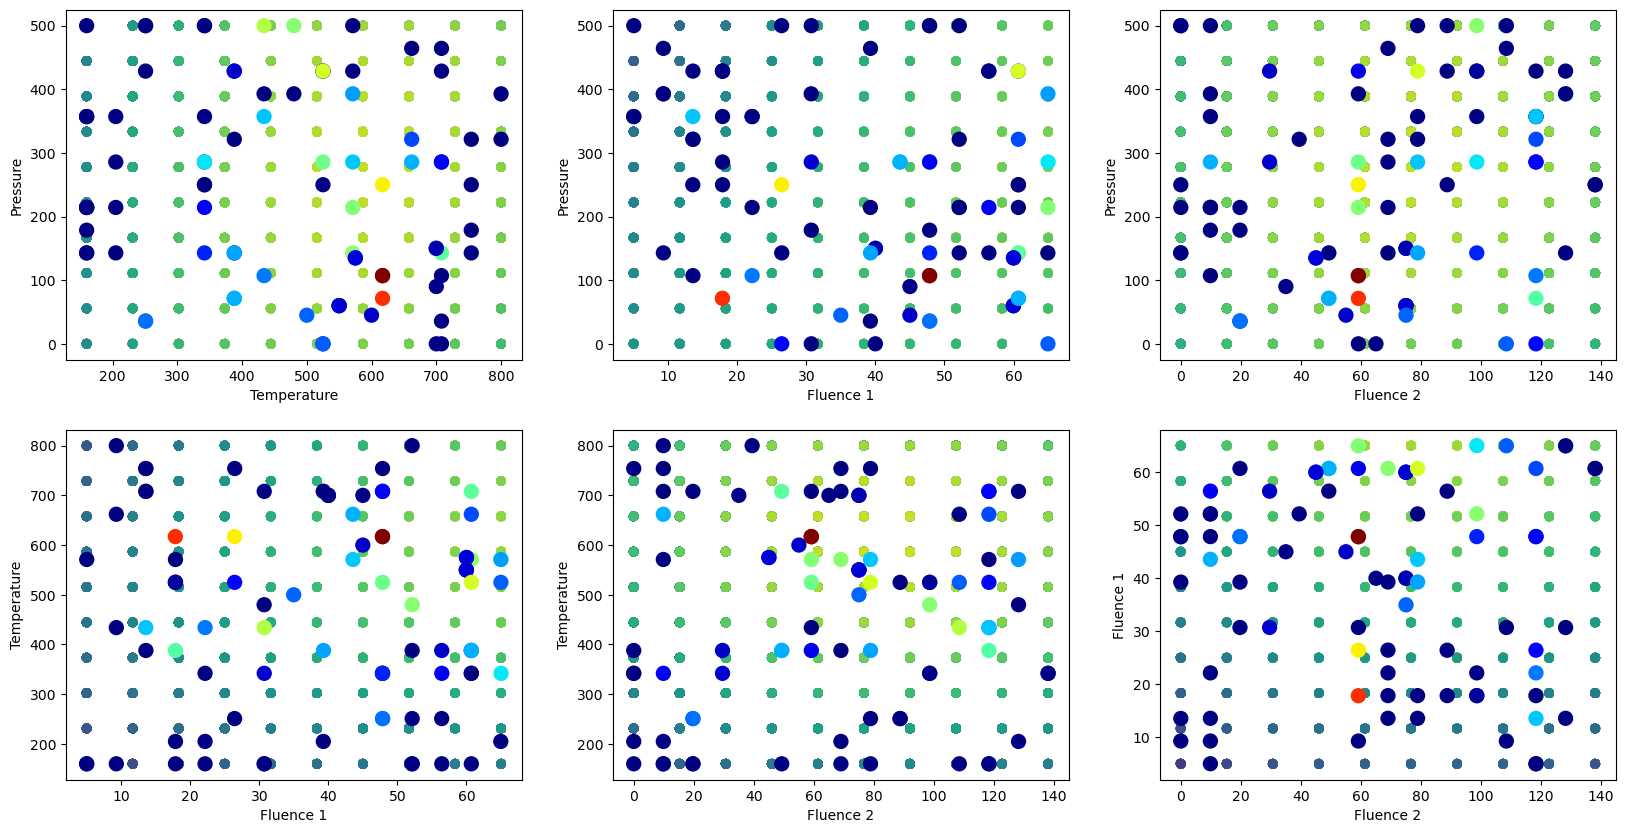

In [47]:
train_params = params[train_indices]

y_GPmean, _, _ = parameter_mapping(train_params, train_y, orig_params, param_divs = [10, 10, 10, 10], plot_GP = True)



# DKL with RCNN

In [68]:

datafile = 'data/PLD data.json'

# Get the dataset, for RCNN, the images_sequence is shaped as: (batch_size=127, seq_len=50, classes =1, width=40, height=40)
dataset1 = ICCDDataset(datafile, image_for_rcnn = True)


# Define the transform1
transform = transforms.RandomAffine(180,
                                    translate=(0.1,0.1),
                                    shear=10,
                                    scale=(0.8,1.2))
# Define the dataset with the transform
dataset2 = ICCDDataset(datafile, transform = transform, image_for_rcnn = True)


# Define the transform with Gaussian noise
transform_with_noise = transforms.Compose([
    transforms.RandomAffine(180, translate=(0.1, 0.1), shear=10, scale=(0.8, 1.2)),
    AddGaussianNoise(mean=0.0, std=0.1)
])

# Define the noise for parameters
param_noise = AddGaussianNoise(mean=0.0, std=0.1)

# Define the dataset with the transform and noise
dataset3 = ICCDDataset(datafile, transform=transform_with_noise, params_noise=param_noise, image_for_rcnn = True)


# Combine the datsets
dataset = ConcatDataset([dataset1, dataset2, dataset3])


In [69]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

X, orig_params, score,_ = extract_data(dataloader, norm = False)
X, params, y, indices = extract_data(dataloader)


In [120]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.2)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
test_dataset = TrainDataset(test_X, test_params, test_y, transform = None)

torch.Size([304, 50, 1, 40, 40]) torch.Size([304, 1]) torch.Size([77, 50, 1, 40, 40]) torch.Size([77, 1])


In [33]:
from custom_models import RCNN_FeatureExtractor, Mixed_RCNN_FeatureExtractor

In [127]:
custom_nn = Mixed_RCNN_FeatureExtractor(output_dim = 20)


Training:  18%|████                   | 35/200 [00:15<01:11,  2.29it/s, Training Loss=-.0428, Test Loss=-.0187]


Training:  36%|████████▏              | 71/200 [00:31<00:56,  2.28it/s, Training Loss=-.0408, Test Loss=-.0212]


Training:  53%|████████████▏          | 106/200 [00:46<00:41,  2.28it/s, Training Loss=0.154, Test Loss=-.0184]


Training:  71%|████████████████▎      | 142/200 [01:02<00:25,  2.29it/s, Training Loss=0.126, Test Loss=-.0187]


Training:  88%|████████████████████▎  | 177/200 [01:18<00:10,  2.21it/s, Training Loss=0.153, Test Loss=-.0198]


Training: 100%|███████████████████████| 200/200 [01:28<00:00,  2.24it/s, Training Loss=0.285, Test Loss=0.0277]
                                                                                                               

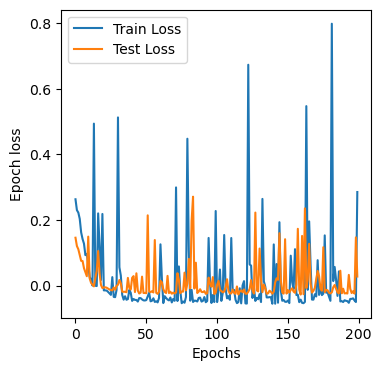

training_loss 0.285372154397816
Test loss 0.027680872062151456


In [128]:
model, training_loss, test_loss = train_test_mixed_nn_DKL(train_dataset,test_dataset, custom_nn, num_epochs = 200, plot_loss = True)
print("training_loss", training_loss[-1])
print("Test loss", test_loss[-1])

In [79]:
y_means, y_vars = DKL_posterior(model, X, params = params)
y_means.shape, y_vars.shape

print(y_means.mean(), y_vars.mean())


tensor(0.1629) tensor(0.0002)


In [25]:
acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y)
ind = np.random.choice(acq_ind)

print(ind)

97


## Active Learning

In [116]:
train_X, test_X, train_params, test_params, train_y, test_y, train_indices, test_indices =train_test_split(X, params, y, indices, test_size=0.6)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_dataset = TrainDataset(train_X, train_params, train_y, transform = None)
intial_train = len(train_dataset)

torch.Size([152, 50, 1, 40, 40]) torch.Size([152, 1]) torch.Size([229, 50, 1, 40, 40]) torch.Size([229, 1])


In [117]:
#Set the number of exploration steps
exploration_steps = 10
beta = 1
for i in range(exploration_steps):

    print(f"\n------------------Exploration Step:{i+1} ----------------------- ")
    custom_nn = Mixed_RCNN_FeatureExtractor(output_dim = 5)

    device  = "cuda" if torch.cuda.is_available() else 'cpu'

    # Contruct the GP surrogate function
    model, training_loss = train_mixed_nn_DKL(train_dataset, custom_nn, num_epochs = 200, device= device, n_batches = 1)
    print("training_loss", training_loss[-1])

    # Calculate the predicted posterior mean and variance
    y_means, y_vars = DKL_posterior(model, X, params=params)

    # Calculate the acquisition function
    #acq_ind, acq_val_max, Acq_vals = acq_fn_EI(y_means, y_vars, train_y, index_exclude= train_indices)
    
    #UCB acquisition function
    beta = 0.8*beta
    acq_ind, acq_val_max, Acq_vals = acq_fn_UCB(y_means, y_vars, beta = beta, index_exclude= train_indices)


    # best estimates
    #X_best_train, X_best_pred = best_mean_estimate(train_X, train_y, X, y_means)

    ind = np.random.choice(acq_ind)
   

    #Next measurement point
    #next_X = X[ind,:]
    next_score = score[ind,:]
    
    # #Plot the results
    # plot_results(X_train, y_train, X, y_means, y_vars, Acq_vals, X_best_train, ind)

    #Print the results
    #print("Next Acquisition at: ", next_X)
    print("Next-index: ",ind)
    print("Measured score: ", next_score.item())
   

    #Update training data
    train_X, train_y, train_params, train_indices = append_to_train(X, y,params, train_X, train_y, train_params, train_indices, ind)


------------------Exploration Step:1 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:03<00:18,  8.95it/s, Loss=0.000638]


Training:  36%|█████████████████▍                               | 71/200 [00:07<00:13,  9.32it/s, Loss=8.36e-6]


Training:  53%|█████████████████████████▍                      | 106/200 [00:11<00:10,  9.24it/s, Loss=-9.9e-5]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:15<00:06,  9.29it/s, Loss=-.000136]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:19<00:02,  9.35it/s, Loss=-.000156]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:21<00:00,  8.94it/s, Loss=-.000164]
                                                                                                               

training_loss -0.00016437807676260207
Next-index:  53
Measured score:  6.600114345550537

------------------Exploration Step:2 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:03<00:18,  8.99it/s, Loss=0.000644]


Training:  36%|█████████████████▍                               | 71/200 [00:07<00:14,  9.02it/s, Loss=2.38e-5]


Training:  53%|████████████████████████▉                      | 106/200 [00:11<00:10,  9.05it/s, Loss=-9.43e-5]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:15<00:06,  9.09it/s, Loss=-.000135]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:19<00:02,  9.15it/s, Loss=-.000155]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:22<00:00,  9.10it/s, Loss=-.000164]
                                                                                                               

training_loss -0.00016422614828854088
Next-index:  156
Measured score:  0.5155255794525146

------------------Exploration Step:3 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:03<00:18,  9.00it/s, Loss=0.000565]


Training:  36%|█████████████████                               | 71/200 [00:07<00:14,  8.98it/s, Loss=-.000173]


Training:  53%|████████████████████████▉                      | 106/200 [00:11<00:10,  8.99it/s, Loss=-.000209]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:15<00:06,  8.98it/s, Loss=-.000284]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:19<00:02,  8.98it/s, Loss=-.000258]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:22<00:00,  8.99it/s, Loss=-.000328]
                                                                                                               

training_loss -0.00032805629400186156
Next-index:  230
Measured score:  0.0

------------------Exploration Step:4 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:04<00:19,  8.31it/s, Loss=0.000645]


Training:  36%|█████████████████▍                               | 71/200 [00:08<00:15,  8.22it/s, Loss=2.09e-5]


Training:  53%|████████████████████████▉                      | 106/200 [00:12<00:11,  8.20it/s, Loss=-9.51e-5]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:17<00:07,  8.22it/s, Loss=-.000135]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:21<00:02,  8.17it/s, Loss=-.000155]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:24<00:00,  8.23it/s, Loss=-.000164]
                                                                                                               

training_loss -0.00016449292696403623
Next-index:  256
Measured score:  2.032789468765259

------------------Exploration Step:5 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:04<00:20,  8.19it/s, Loss=0.000567]


Training:  36%|█████████████████                               | 71/200 [00:08<00:15,  8.20it/s, Loss=-5.82e-5]


Training:  53%|████████████████████████▉                      | 106/200 [00:12<00:11,  8.23it/s, Loss=-.000269]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:17<00:07,  7.64it/s, Loss=-.000308]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:21<00:02,  8.12it/s, Loss=-.000374]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:24<00:00,  8.28it/s, Loss=-.000395]
                                                                                                               

training_loss -0.00039549791949024704
Next-index:  309
Measured score:  0.3775647282600403

------------------Exploration Step:6 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:04<00:20,  8.14it/s, Loss=0.000644]


Training:  36%|█████████████████▍                               | 71/200 [00:08<00:15,  8.11it/s, Loss=1.48e-5]


Training:  53%|████████████████████████▉                      | 106/200 [00:12<00:11,  8.23it/s, Loss=-9.75e-5]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:17<00:07,  8.08it/s, Loss=-.000136]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:21<00:02,  8.14it/s, Loss=-.000156]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:24<00:00,  8.09it/s, Loss=-.000164]
                                                                                                               

training_loss -0.00016430579608760183
Next-index:  42
Measured score:  164.1488494873047

------------------Exploration Step:7 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:04<00:20,  8.06it/s, Loss=0.000467]


Training:  36%|█████████████████                               | 71/200 [00:08<00:16,  8.04it/s, Loss=-.000275]


Training:  53%|████████████████████████▉                      | 106/200 [00:13<00:11,  8.32it/s, Loss=-.000373]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:17<00:06,  8.42it/s, Loss=-.000519]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:21<00:02,  8.49it/s, Loss=-.000452]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:24<00:00,  8.46it/s, Loss=-.000538]
                                                                                                               

training_loss -0.0005375134150702448
Next-index:  289
Measured score:  0.33356067538261414

------------------Exploration Step:8 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:04<00:19,  8.66it/s, Loss=0.000583]


Training:  36%|█████████████████                               | 71/200 [00:08<00:14,  8.74it/s, Loss=-5.84e-5]


Training:  53%|████████████████████████▉                      | 106/200 [00:12<00:10,  8.72it/s, Loss=-.000138]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:16<00:06,  8.78it/s, Loss=-.000185]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:20<00:02,  8.72it/s, Loss=-.000145]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:23<00:00,  8.78it/s, Loss=-.000163]
                                                                                                               

training_loss -0.0001626402951455091
Next-index:  280
Measured score:  4.02393102645874

------------------Exploration Step:9 ----------------------- 



Training:  18%|████████▍                                       | 35/200 [00:03<00:18,  8.70it/s, Loss=0.000644]


Training:  36%|█████████████████▍                               | 71/200 [00:08<00:14,  8.66it/s, Loss=1.83e-5]


Training:  53%|████████████████████████▉                      | 106/200 [00:12<00:10,  8.80it/s, Loss=-9.77e-5]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:16<00:06,  8.71it/s, Loss=-.000136]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:20<00:02,  8.83it/s, Loss=-.000156]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:23<00:00,  8.81it/s, Loss=-.000165]
                                                                                                               

training_loss -0.00016465268410579737
Next-index:  181
Measured score:  0.5026738047599792

------------------Exploration Step:10 ----------------------- 



Training:  18%|████████▌                                        | 35/200 [00:03<00:17,  9.44it/s, Loss=0.00065]


Training:  36%|█████████████████▍                               | 71/200 [00:07<00:13,  9.38it/s, Loss=3.99e-5]


Training:  53%|█████████████████████████▍                      | 106/200 [00:11<00:11,  8.09it/s, Loss=-7.8e-5]


Training:  71%|█████████████████████████████████▎             | 142/200 [00:15<00:06,  9.26it/s, Loss=-.000127]


Training:  88%|█████████████████████████████████████████▌     | 177/200 [00:19<00:02,  9.17it/s, Loss=-.000152]


Training: 100%|███████████████████████████████████████████████| 200/200 [00:21<00:00,  8.85it/s, Loss=-.000162]
                                                                                                               

training_loss -0.0001617568624150221
Next-index:  122
Measured score:  3.0577242374420166


In [118]:
score_np = score.detach().squeeze().numpy()
initial_train_indices = train_indices[0:initial_train]
active_learning_indices = train_indices[initial_train:]

print("Inital training score:", score_np[initial_train_indices].mean())
print("Average dataset score:", score_np.mean())
print("Average Active-learning score:", score_np[active_learning_indices].mean()) 

Inital training score: 64.98718
Average dataset score: 77.027756
Average Active-learning score: 81.132835


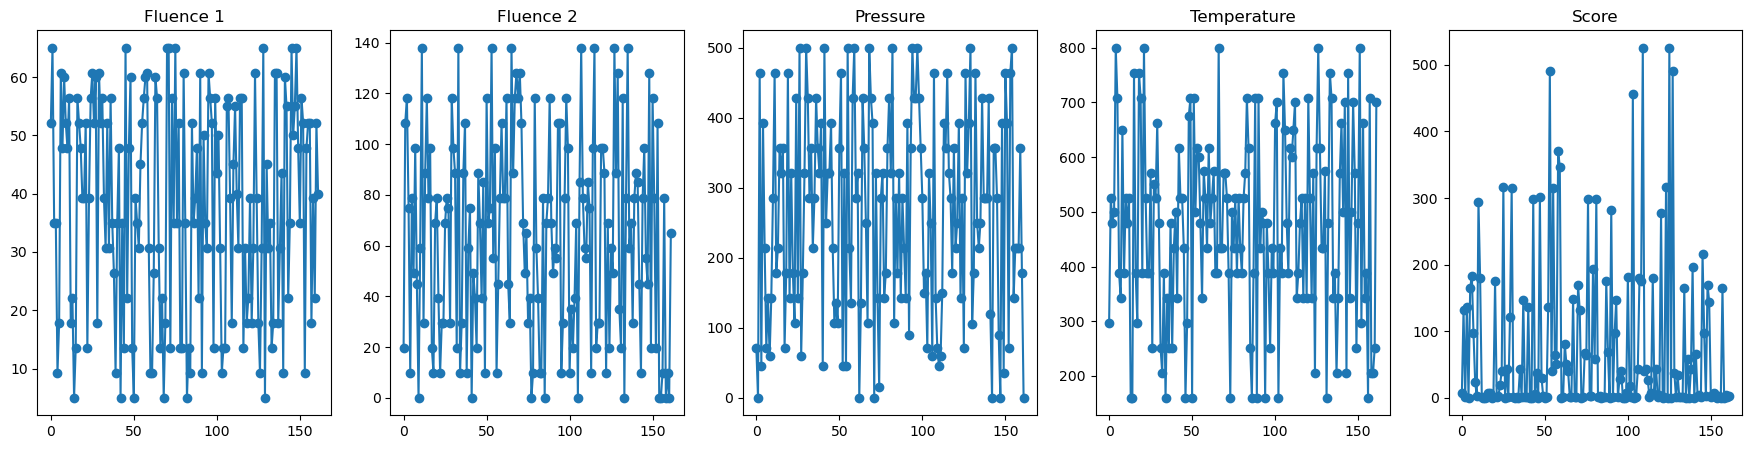

In [119]:
plot_train_series(train_indices, orig_params, score)

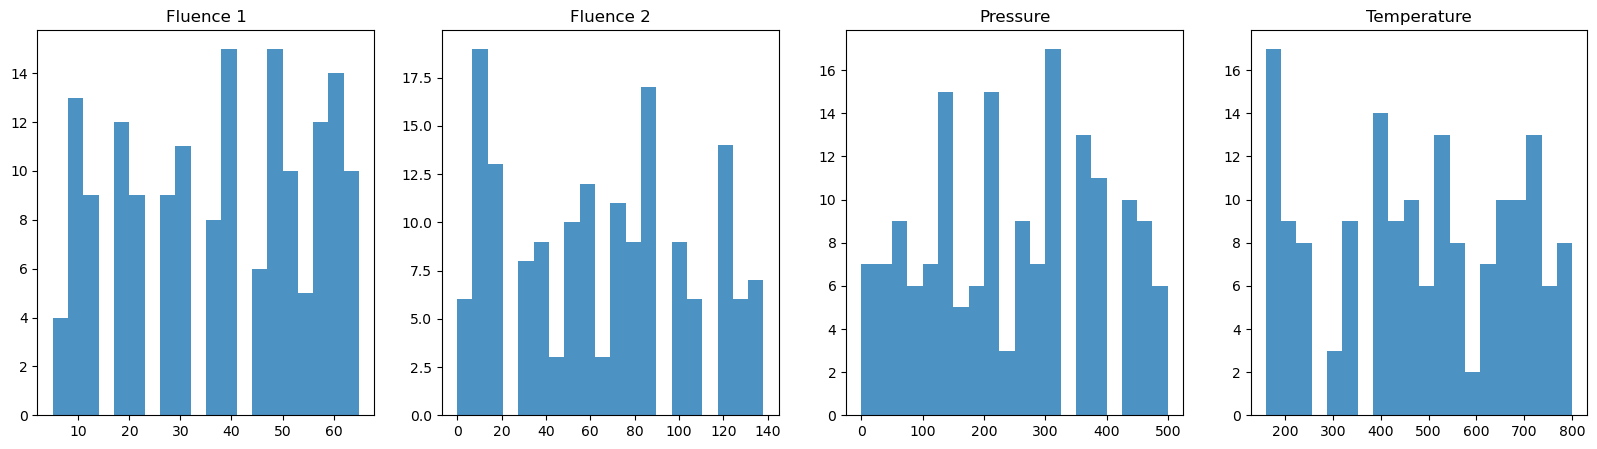

In [108]:
plot_train_hist(train_indices, orig_params)

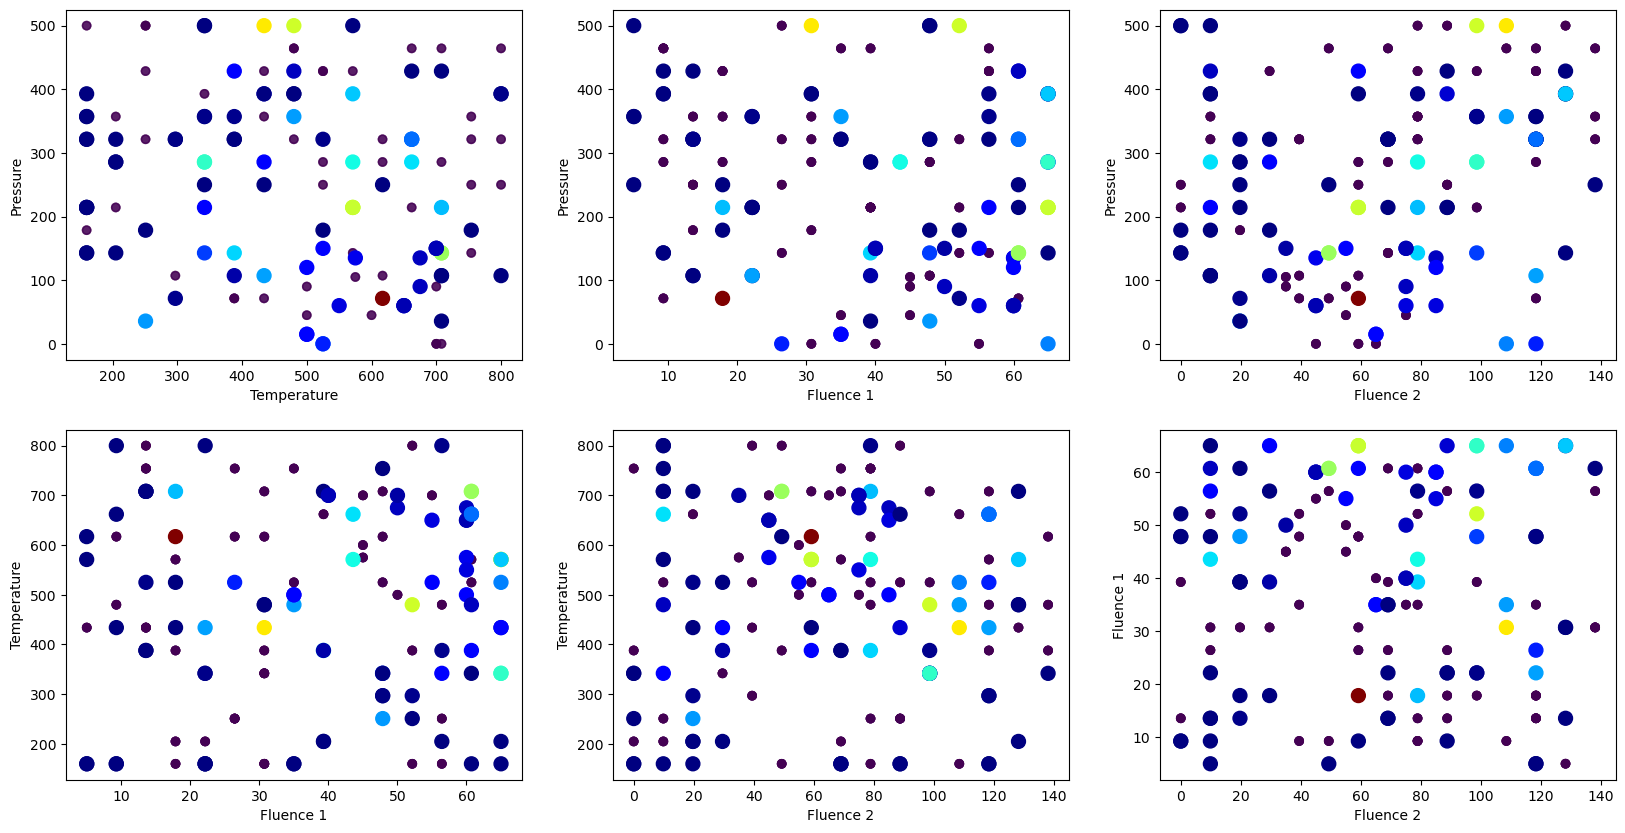

In [85]:
plot_mean_map(y_means, train_indices, orig_params, score)

training_loss -0.000941847027702765


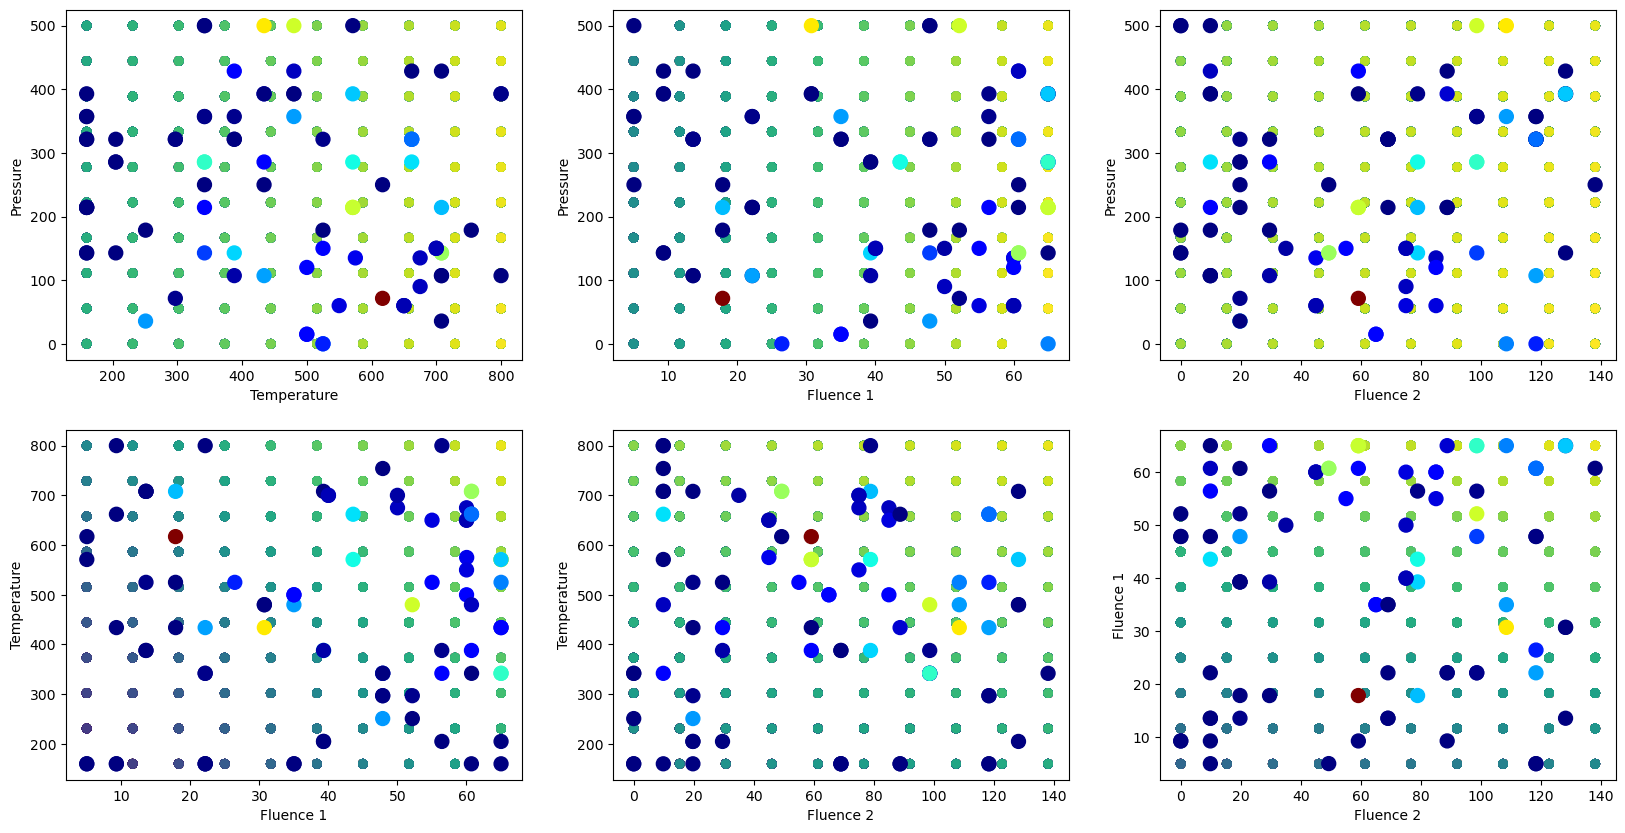

In [86]:
train_params = params[train_indices]

y_GPmean, _, _ = parameter_mapping(train_params, train_y, orig_params, param_divs = [10, 10, 10, 10], plot_GP = True, num_epochs = 250)
